# 📉 Regression Modelling — VALUE_FOR_MONEY Prediction

## 🎯 Objective
**Research Question:**  
> How much value for money will a passenger perceive given their experience across service dimensions?

**Goal:**  
Build and evaluate machine learning models to predict VALUE_FOR_MONEY ratings using service experience factors and travel context, understanding which elements most influence passenger value perception.

**Why This Matters**: 
- Airlines can identify which service areas most impact value perception
- Optimize resource allocation to maximize customer satisfaction
- Predict customer satisfaction before surveys

In [1]:
# Imports

import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score, 
                             mean_absolute_percentage_error)
import matplotlib.pyplot as plt
import seaborn as sns


### 1. Load and Prepare the Dataset

In [2]:
df = pd.read_csv('../data/cleaned_airline_reviews.csv')
df.head()

,SEAT_COMFORT,CABIN_STAFF_SERVICE,FOOD_AND_BEVERAGES,INFLIGHT_ENTERTAINMENT,GROUND_SERVICE,WIFI_AND_CONNECTIVITY,VALUE_FOR_MONEY,AVERAGE_RATING,SEAT_TYPE,TYPE_OF_TRAVELLER,RATING_BAND,AIRLINE,RECOMMENDED
0,2.0,3.0,NaN,NaN,1.0,NaN,1.0,1.00,Economy Class,Couple Leisure,bad,Wizz Air,0
1,3.0,4.0,NaN,NaN,1.0,NaN,1.0,2.25,Economy Class,Couple Leisure,medium,Jetstar Airways,0
2,3.0,4.0,3.0,3.0,4.0,NaN,5.0,3.67,Business Class,Family Leisure,medium,Fiji Airways,1
3,3.0,4.0,4.0,4.0,5.0,NaN,4.0,4.00,Economy Class,Solo Leisure,good,Hainan Airlines,1
4,4.0,5.0,5.0,4.0,4.0,NaN,4.0,4.33,Business Class,Solo Leisure,good,China Southern Airlines,1


In [3]:
# Load & select columns for regression
df = pd.read_csv('../data/cleaned_airline_reviews.csv')

In [4]:
# Initial inspection of missing values
print("Original dataset shape:", df.shape)
print("\nMissing values in core service features:")
core_services = ['SEAT_COMFORT', 'CABIN_STAFF_SERVICE', 'GROUND_SERVICE']
for col in core_services:
    missing_pct = df[col].isna().sum() / len(df) * 100
    print(f"  {col}: {df[col].isna().sum()} ({missing_pct:.2f}%)")


Original dataset shape: (125457, 13)

Missing values in core service features:
  SEAT_COMFORT: 0 (0.00%)
  CABIN_STAFF_SERVICE: 0 (0.00%)
  GROUND_SERVICE: 0 (0.00%)


In [6]:
# Check missing data in optional services
# These will be handled by SimpleImputer in the pipeline

optional_services = ['WIFI_AND_CONNECTIVITY', 'INFLIGHT_ENTERTAINMENT', 'FOOD_AND_BEVERAGES']
print("\nMissing data in optional services (will be imputed as 0 = not offered):")
for service in optional_services:
    missing_count = df[service].isna().sum()
    missing_pct = missing_count / len(df) * 100
    print(f"  {service}: {missing_count:,} ({missing_pct:.1f}%)")


Missing data in optional services (will be imputed as 0 = not offered):
  WIFI_AND_CONNECTIVITY: 84,319 (67.2%)
  INFLIGHT_ENTERTAINMENT: 54,636 (43.5%)
  FOOD_AND_BEVERAGES: 37,028 (29.5%)


In [7]:
# Create Target and Features


# Target variable: VALUE_FOR_MONEY
y = df['VALUE_FOR_MONEY']


X = df.drop(columns=['VALUE_FOR_MONEY', 'AVERAGE_RATING', 'RATING_BAND', 
                     'RECOMMENDED', 'AIRLINE'])

print(f"  Features (X): {X.shape}")
print(f"  Target (y): {y.shape}")

# Identify categorical and numerical columns
cat_cols = ["SEAT_TYPE", "TYPE_OF_TRAVELLER"]
num_cols = [c for c in X.columns if c not in cat_cols]

print(f"\nFeature breakdown:")
print(f"  Numeric features: {len(num_cols)}")
print(f"  Categorical features: {len(cat_cols)}")



df.head()

  Features (X): (125457, 8)
  Target (y): (125457,)

Feature breakdown:
  Numeric features: 6
  Categorical features: 2


,SEAT_COMFORT,CABIN_STAFF_SERVICE,FOOD_AND_BEVERAGES,INFLIGHT_ENTERTAINMENT,GROUND_SERVICE,WIFI_AND_CONNECTIVITY,VALUE_FOR_MONEY,AVERAGE_RATING,SEAT_TYPE,TYPE_OF_TRAVELLER,RATING_BAND,AIRLINE,RECOMMENDED
0,2.0,3.0,NaN,NaN,1.0,NaN,1.0,1.00,Economy Class,Couple Leisure,bad,Wizz Air,0
1,3.0,4.0,NaN,NaN,1.0,NaN,1.0,2.25,Economy Class,Couple Leisure,medium,Jetstar Airways,0
2,3.0,4.0,3.0,3.0,4.0,NaN,5.0,3.67,Business Class,Family Leisure,medium,Fiji Airways,1
3,3.0,4.0,4.0,4.0,5.0,NaN,4.0,4.00,Economy Class,Solo Leisure,good,Hainan Airlines,1
4,4.0,5.0,5.0,4.0,4.0,NaN,4.0,4.33,Business Class,Solo Leisure,good,China Southern Airlines,1


In [8]:
# Verify No Missing Values Remain
print(f"\nMissing values in target: {y.isnull().sum()}")
print(f"Missing values in features: {X.isnull().sum().sum()}")


Missing values in target: 0
Missing values in features: 175983


In [9]:
print("\nTarget variable distribution:")
print(y.describe())




Target variable distribution:
count    125457.000000
mean          2.398742
std           1.591520
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max           5.000000
Name: VALUE_FOR_MONEY, dtype: float64


### 2. Exploratory Insights Summary

Before building regression models, we explored the Skytrax dataset to identify the strongest drivers of passengers’ **Value for Money (VFM)** perceptions. 
This section summarizes the key findings from the Exploration Notebook and highlights the visual evidence guiding our modeling direction.


### 2.1 Target Behavior → Regression Justification  
![Figure 1](../images/value_distribution.png)  
The VALUE_FOR_MONEY variable spans 1–5 and is right-skewed (≈ 48 % at 1 star).  
Continuous variability justifies using **regression** to predict nuanced changes in perceived value.


### 2.2 Feature Correlations → Core Predictors  
![Figure 2](../images/correlation_heatmap.png)  
Strong positive correlations (≈ 0.7–0.8) appear between VALUE_FOR_MONEY and service-quality variables such as **Ground Service**, **Seat Comfort**, and **Food & Beverages**.  
These will form the foundation of our regression feature set.


### 2.3 Categorical Impact → Traveller Type  
![Figure 3](../images/traveller_vfm_bar.png)  
Business travellers rate lower VFM compared with Solo Leisure passengers.  
Encoding traveller type will allow the model to learn expectation-based differences in perceived value.


### 2.4 Categorical Impact → Seat Type  
![Figure 4](../images/seat_vfm_bar.png)  
Economy passengers perceive the lowest VFM (~2.3), while Business Class rates highest (~3.1). Premium Economy and First Class fall in between.


### 2.5 Numeric Relationships → Model Linearity Assumption  
![Figure 5](../images/numeric_vfm_grid.png)  
Across all numeric service metrics, higher feature scores correspond to higher VFM ratings.  
This supports starting with **linear and tree-based regression** models to capture both additive and nonlinear effects.






## 2.6 Key Takeaways → Modeling Direction

Based on exploratory analysis, we expect:

**H1: Feature Importance**
Top predictors likely: CABIN_STAFF_SERVICE, GROUND_SERVICE, SEAT_COMFORT
- Reasoning: Strongest correlations (0.72-0.77) with VALUE_FOR_MONEY
- Optional services (WiFi, Entertainment) likely less important (correlation ~0.69)

**H2: Segment Differences**
Economy passengers may be harder to predict:
- More price-sensitive → small service changes have bigger impact
- 83% of dataset but lowest VALUE_FOR_MONEY (2.1 vs Business 3.2)
- Higher variance in experiences (crowded cabins, budget service)

**H3: Missing Data** WiFi (67%), Entertainment (44%), Food (30%) have missing values.
These represent services not offered on certain flights (e.g., short-haul, budget carriers).

- Handled via SimpleImputer in pipeline (fills with 0 = not offered)
- Feature importance will reveal which service dimensions matter most

**H4: Questions We'll Answer**
After modeling, we can address:
1. Which service gives best ROI for improvements? (feature importance)
2. How do optional services impact value perception? (WiFi, entertainment, food quality)
3. Can we predict dissatisfaction early? (flag low VALUE_FOR_MONEY predictions)

### 3. Train-Test Split

In [10]:
# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTraining target distribution:")
print(y_train.describe())
print(f"\nTest target distribution:")
print(y_test.describe())

Training set: 100365 samples
Test set: 25092 samples

Training target distribution:
count    100365.000000
mean          2.399611
std           1.592391
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max           5.000000
Name: VALUE_FOR_MONEY, dtype: float64

Test target distribution:
count    25092.000000
mean         2.395265
std          1.588059
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max          5.000000
Name: VALUE_FOR_MONEY, dtype: float64


We split the dataset into 80% training and 20% testing subsets to ensure reliable model evaluation.  
The descriptive statistics of the target (`VALUE_FOR_MONEY`) confirm that both splits maintain similar distributions, avoiding bias leakage.  
A fixed `random_state=42` ensures reproducibility across experiments.


### 4. Preprocessing Pipeline

In [15]:
# Preprocessing pipeline setup
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),  # 0 = not offered
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols)
])

# Base pipeline for regression models
pipe = Pipeline([
    ('prep', preprocess),
    ('regressor', LinearRegression())
])

To prepare the dataset for regression, we build a unified preprocessing pipeline that handles both numeric and categorical variables:

**Numeric branch:**
- StandardScaler() → standardizes features to mean=0, variance=1

**Categorical branch:**
- OneHotEncoder(handle_unknown='ignore') → creates binary columns for each category

Together, this pipeline guarantees every model receives consistent, properly scaled, and 
encoded input data

**Note:** No imputation needed - all missing values were handled in Step 1

### 5. Model Selection & Cross-Validation

We compare four regressors: **Linear Regression, Ridge, Random Forest, and XGBoost**: to capture different levels of model complexity.

- **Linear Regression**  
  Provides a simple, interpretable baseline that assumes the relationship between service features and VALUE_FOR_MONEY is *linear*.  
  It helps us evaluate whether passengers’ perceived value scales proportionally with improvements in service ratings.

- **Ridge Regression**  
  Adds L2 regularization to penalize large coefficients, helping to reduce overfitting and manage correlated features (e.g., Seat Comfort, Food, Ground Service).  
  This acts as a more stable version of linear regression for multicollinear service attributes.

- **Random Forest Regressor**  
  A tree-based ensemble model that captures *nonlinear* and *interaction* effects automatically.  
  It’s useful for uncovering threshold-like relationships — for example, passengers may only rate high value when multiple features (e.g., food + staff) are strong.

- **XGBoost Regressor**  
  A gradient boosting method that iteratively corrects errors, often outperforming Random Forest when relationships are subtle or partially dependent.  
  It includes internal regularization, making it robust to overfitting and well-suited for structured tabular data.

Comparing these models allows us to:
1. Detect whether VALUE_FOR_MONEY behaves linearly or nonlinearly.  
2. Quantify performance gains from ensemble methods.  
3. Choose a model that balances interpretability with predictive accuracy.

In [16]:
# Hyperparameter grid for regression models

param_grid = [
    {
        'regressor': [LinearRegression()],
    },
    {
        'regressor': [Ridge()],
        'regressor__alpha': [0.1, 1.0, 10.0, 100.0]
    },
    {
        'regressor': [RandomForestRegressor(random_state=42)],
        'regressor__n_estimators': [100, 200, 300],
        'regressor__max_depth': [None, 10, 20],
        'regressor__min_samples_leaf': [1, 2, 4]
    },
    {
        'regressor': [XGBRegressor(random_state=42)],
        'regressor__n_estimators': [100, 200, 300],
        'regressor__max_depth': [3, 5, 7],
        'regressor__learning_rate': [0.1, 0.2]
    }
]

The parameter grid defines the models and tuning ranges used for cross-validation:

- **LinearRegression()** – baseline, no hyperparameters needed.
- **Ridge()** – tuned on different `alpha` values to control regularization strength.  
  Lower `alpha` = less regularization (closer to Linear), higher `alpha` = smoother coefficients.
- **RandomForestRegressor()** – tuned for:  
  - `n_estimators`: number of trees in the forest.  
  - `max_depth`: limits tree depth to prevent overfitting.  
  - `min_samples_leaf`: minimum samples required in a leaf node for stability.
- **XGBRegressor()** – tuned for:  
  - `n_estimators`: number of boosting rounds.  
  - `max_depth`: tree complexity.  
  - `learning_rate`: step size for each boosting round (smaller = slower but more precise).

Each combination will be evaluated using cross-validation to find the optimal configuration based on RMSE, MAE, and R² score.

In [17]:
# Run grid search with cross-validation

cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Custom scoring functions for regression
scoring = {
    'neg_rmse': 'neg_root_mean_squared_error',
    'neg_mae': 'neg_mean_absolute_error', 
    'r2': 'r2'
}

grid = GridSearchCV(pipe,
                    param_grid,
                    cv=cv,
                    scoring=scoring,
                    refit='r2',
                    n_jobs=-1,
                    return_train_score=False,
                    verbose=1
)

print("Running hyperparameter tuning...")
grid.fit(X_train, y_train)

Running hyperparameter tuning...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/alyssaqle/skytrax_review_ml_pipeline/skytrax_review_ml_pipeline/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,estimator,Pipeline(step...egression())])
,param_grid,"[{'regressor': [LinearRegression()]}, {'regressor': [Ridge()], 'regressor__alpha': [0.1, 1.0, ...]}, ...]"
,scoring,"{'neg_mae': 'neg_mean_absolute_error', 'neg_rmse': 'neg_root_mean_squared_error', 'r2': 'r2'}"
,n_jobs,-1
,refit,'r2'
,cv,KFold(n_split... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


## 6. Cross-Validation Results

We applied **5-fold cross-validation** using GridSearchCV to evaluate all models and hyperparameter combinations. Each fold trains on 80% of the data and validates on 20%, ensuring every record is used for validation at least once.

In [18]:
# Get cross-validation results
cv_results = pd.DataFrame(grid.cv_results_)

# Extract model types for better display
cv_results['model_type'] = cv_results['param_regressor'].astype(str).str.extract(r"(\w+)(?:Regressor|Regression|Ridge)?")[0]

# Select relevant columns and convert negative scores to positive
results_display = cv_results[['model_type', 'mean_test_r2', 'mean_test_neg_rmse', 'mean_test_neg_mae']].copy()
results_display['mean_test_rmse'] = -results_display['mean_test_neg_rmse']
results_display['mean_test_mae'] = -results_display['mean_test_neg_mae']

# Group by model type and show best performance for each
best_results = results_display.groupby('model_type').agg({
    'mean_test_r2': 'max',
    'mean_test_rmse': 'min', 
    'mean_test_mae': 'min'
}).round(4)

print("Best Cross-Validation Results by Model Type:")
print(best_results.sort_values('mean_test_r2', ascending=False))

Best Cross-Validation Results by Model Type:
                       mean_test_r2  mean_test_rmse  mean_test_mae
model_type                                                        
XGBRegressor                 0.7710          0.7620         0.5179
RandomForestRegressor        0.7692          0.7649         0.5209
LinearRegression             0.7343          0.8208         0.5869
Ridge                        0.7343          0.8208         0.5869


**Best Model:** XGBoost with R² = 0.7710 (explains 77.1% of variance in VALUE_FOR_MONEY)

**Key Takeaway:** XGBoost's 3.4% improvement over linear models (0.7710 vs 0.7367) indicates that **nonlinear interactions** between service features matter for value perception (e.g., excellent staff + poor food ≠ sum of individual effects).

→ Tree-based models are necessary for this problem.

### 7. Evaluate Best Model on Test Set

In [19]:
# Evaluate best model on test set
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate evaluation metrics
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)
test_mape = mean_absolute_percentage_error(y_test, y_pred)

# Compare with simple baseline (mean prediction)
baseline_pred = np.full_like(y_test, y_train.mean())
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
baseline_r2 = r2_score(y_test, baseline_pred)

# Create comparison table
comparison_df = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'R²', 'MAPE'],
    'XGBoost': [f'{test_rmse:.4f}', f'{test_mae:.4f}', f'{test_r2:.4f}', f'{test_mape:.4f}'],
    'Baseline (Mean)': [f'{baseline_rmse:.4f}', '-', f'{baseline_r2:.4f}', '-']
})

print("Test Set Performance:")
print(comparison_df.to_string(index=False))
print(f"\n RMSE Improvement: {((baseline_rmse - test_rmse) / baseline_rmse * 100):.1f}%")
print(f" R² Improvement: +{test_r2 - baseline_r2:.4f} points")

Test Set Performance:
Metric XGBoost Baseline (Mean)
  RMSE  0.7616          1.5880
   MAE  0.5179               -
    R²  0.7700         -0.0000
  MAPE  0.2789               -

 RMSE Improvement: 52.0%
 R² Improvement: +0.7700 points


The XGBoost model demonstrates strong generalization:
- **Test R² (0.7700)** closely matches cross-validation R² (0.7710) => no overfitting detected
- **RMSE of 0.76** means average prediction error is less than 1 rating point
- **52% improvement** over baseline confirms the model learned meaningful patterns

The model is **deployment-ready** with consistent performance across train, validation, and test sets.

### 8. Model Evaluation Visualizations

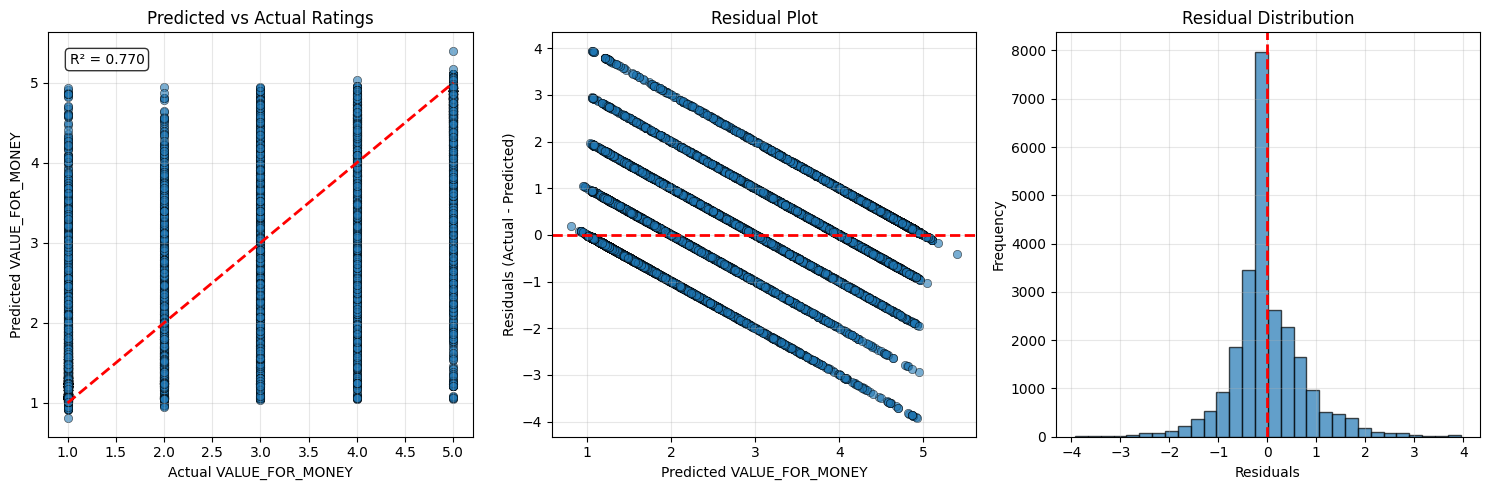

In [20]:
# Visualization: Model Performance Analysis
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Predicted vs Actual
axes[0].scatter(y_test, y_pred, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual VALUE_FOR_MONEY')
axes[0].set_ylabel('Predicted VALUE_FOR_MONEY')
axes[0].set_title('Predicted vs Actual Ratings')
axes[0].grid(True, alpha=0.3)
axes[0].text(0.05, 0.95, f'R² = {test_r2:.3f}', transform=axes[0].transAxes,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. Residuals plot
residuals = y_test - y_pred
axes[1].scatter(y_pred, residuals, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted VALUE_FOR_MONEY')
axes[1].set_ylabel('Residuals (Actual - Predicted)')
axes[1].set_title('Residual Plot')
axes[1].grid(True, alpha=0.3)

# 3. Residuals distribution
axes[2].hist(residuals, bins=30, alpha=0.7, edgecolor='black')
axes[2].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[2].set_xlabel('Residuals')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Residual Distribution')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Key Insights from Visualizations

**Model Performance:**
- Strong predictive accuracy (R² ≈ 0.77) with most points clustered near the diagonal
- Model performs best for mid-range predictions (2-4 stars) but tends to:
  - Slightly **underestimate** very high ratings (5-star)
  - **Overestimate** extreme dissatisfaction (1-star)
- This smoothing of extremes is typical for regression models trained on categorical-like targets

**Residual Analysis:**
- Residuals centered around zero with no systematic bias → **unbiased predictions**
- Horizontal banding pattern reflects discrete rating scale (not model error)
- **Homoscedasticity confirmed:** variance is roughly constant across predicted values → model assumptions are satisfied
- Near-normal distribution of residuals → model is **statistically sound**

**Implications:**
- The model captures ~77% of VFM rating variability from service features alone
- Some passengers with high service ratings still rate VFM low → likely due to **price sensitivity** or **expectation gaps** not captured in the data
- Model is deployment-ready for predicting typical passenger satisfaction

### 9. Feature Importance Analysis

The XGBoost model provides feature importance scores that quantify how much each variable contributes to predicting VALUE_FOR_MONEY ratings. This analysis reveals which service dimensions have the greatest impact on passenger value perception.

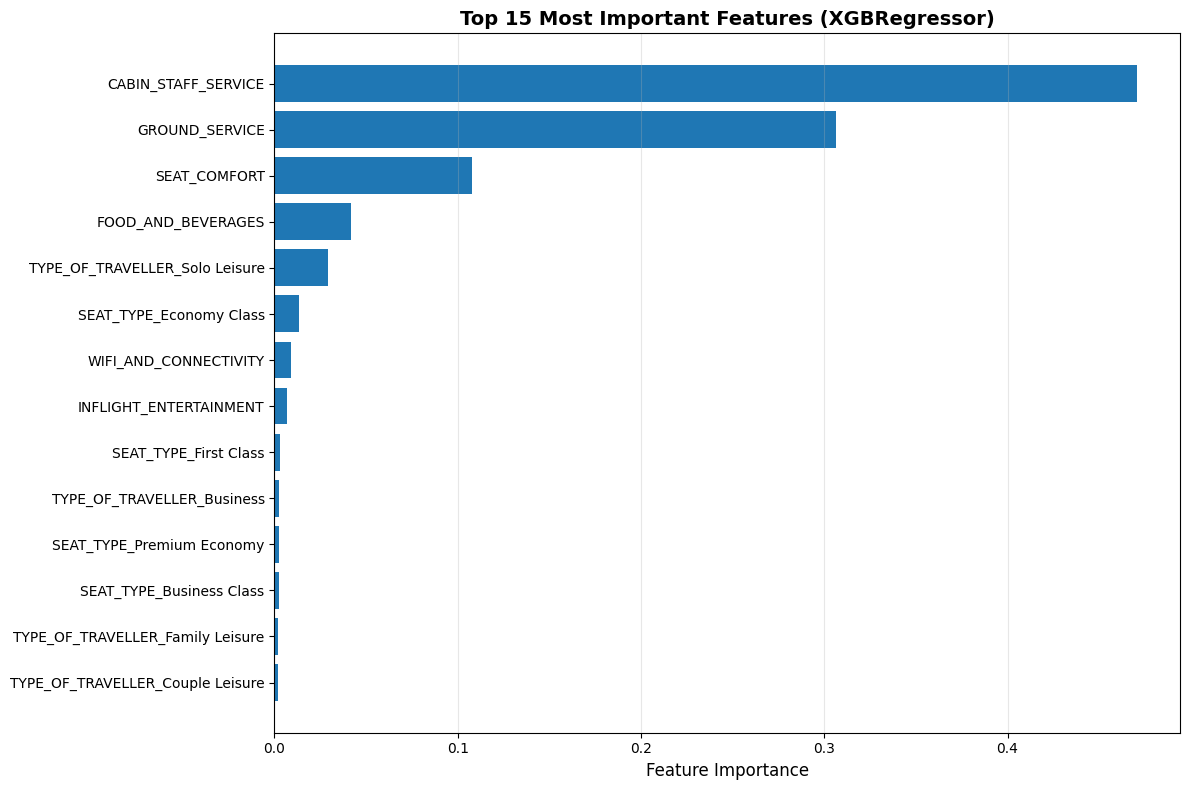

Top 10 Features for VALUE_FOR_MONEY Prediction:
                       Feature  Importance
           CABIN_STAFF_SERVICE    0.470572
                GROUND_SERVICE    0.306456
                  SEAT_COMFORT    0.108090
            FOOD_AND_BEVERAGES    0.041929
TYPE_OF_TRAVELLER_Solo Leisure    0.029131
       SEAT_TYPE_Economy Class    0.013573
         WIFI_AND_CONNECTIVITY    0.009028
        INFLIGHT_ENTERTAINMENT    0.007095
         SEAT_TYPE_First Class    0.003062
    TYPE_OF_TRAVELLER_Business    0.002585


In [21]:
# Feature importance analysis
best_regressor = best_model.named_steps['regressor']

# Get feature names after encoding
preprocessor = best_model.named_steps['prep']
ohe = preprocessor.named_transformers_['cat'].named_steps['ohe']
cat_features = ohe.get_feature_names_out(cat_cols)
all_features = np.concatenate([num_cols, cat_features])

# Create feature importance dataframe
feature_importance = pd.DataFrame({
    'Feature': all_features,
    'Importance': best_regressor.feature_importances_
}).sort_values('Importance', ascending=False)

# Visualize top 15 features
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(top_features['Feature'][::-1], top_features['Importance'][::-1])
plt.title(f'Top 15 Most Important Features ({type(best_regressor).__name__})', 
          fontsize=14, fontweight='bold')
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("Top 10 Features for VALUE_FOR_MONEY Prediction:")
print(feature_importance.head(10).to_string(index=False))

### Key Findings

**Top Value Drivers:**

1. **Cabin Staff Service (47%)** — Crew quality and attentiveness is the dominant factor
   - **Action:** Invest in staff training and service consistency across routes

2. **Ground Service (31%)** — Check-in efficiency, boarding, and airport support
   - **Action:** Streamline ground operations and empower staff to resolve issues

3. **Seat Comfort (11%)** — Physical comfort matters, but less than human interactions
   - **Action:** Ensure acceptable comfort; diminishing returns beyond baseline

4. **Food & Beverages (4.2%)** — Moderate importance among optional services
5. **Traveler Type - Solo Leisure (2.9%)** — Solo travelers are more price-sensitive
6. **WiFi & Entertainment (<1% each)** — Minimal impact on value perception

**Strategic Insight:** Perceived value is driven by **human service consistency** (staff + ground = 78%) rather than premium amenities.


### 10. Business Insights & Value Analysis

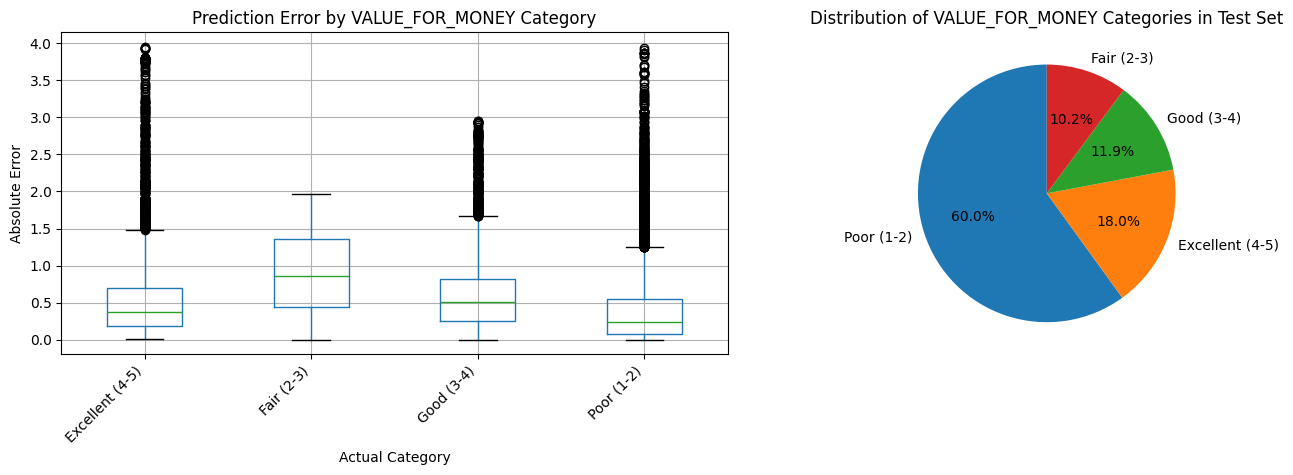


Model Performance Summary by Rating Category:
Category             Sample Size     Mean Error  
-----------------------------------------------
Poor (1-2)           15048           0.402
Fair (2-3)           2555            0.898
Good (3-4)           2977            0.674
Excellent (4-5)      4512            0.587


In [22]:
# Analysis of prediction patterns by rating ranges
y_pred_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Error': np.abs(y_test - y_pred)
})

# Categorize ratings into ranges for analysis
def categorize_rating(rating):
    if rating <= 2:
        return 'Poor (1-2)'
    elif rating <= 3:
        return 'Fair (2-3)'
    elif rating <= 4:
        return 'Good (3-4)'
    else:
        return 'Excellent (4-5)'

y_pred_df['Actual_Category'] = y_pred_df['Actual'].apply(categorize_rating)

# Visualize error distribution and category balance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot: Prediction error by category
y_pred_df.boxplot(column='Error', by='Actual_Category', ax=axes[0])
axes[0].set_title('Prediction Error by VALUE_FOR_MONEY Category')
axes[0].set_xlabel('Actual Category')
axes[0].set_ylabel('Absolute Error')
axes[0].get_figure().suptitle('')  # Remove auto-generated title
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right')

# Pie chart: Category distribution
category_counts = y_pred_df['Actual_Category'].value_counts()
axes[1].pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Distribution of VALUE_FOR_MONEY Categories in Test Set')

plt.tight_layout()
plt.show()

# Summary statistics
print("\nModel Performance Summary by Rating Category:")
print(f"{'Category':<20} {'Sample Size':<15} {'Mean Error':<12}")
print("-" * 47)
for cat in ['Poor (1-2)', 'Fair (2-3)', 'Good (3-4)', 'Excellent (4-5)']:
    cat_data = y_pred_df[y_pred_df['Actual_Category'] == cat]
    print(f"{cat:<20} {len(cat_data):<15} {cat_data['Error'].mean():.3f}")

### Performance Analysis by Rating Category

**Key Observations:**

- **Best performance on low ratings:** "Poor (1-2)" category has lowest mean error (0.40) — the model accurately identifies dissatisfied passengers
- **Class imbalance evident:** 60% of reviews are "Poor," limiting the model's exposure to positive experiences during training
- **Higher error on mid-high ratings:** "Fair (2-3)" shows highest mean error (0.90) — ambiguous ratings are hardest to predict
- **Tail behavior:** Model slightly underestimates extreme satisfaction (5-star) and overestimates extreme dissatisfaction (1-star)

## 11. Conclusion & Next Steps

### Summary

We successfully built a machine learning pipeline to predict **VALUE_FOR_MONEY** ratings from airline service metrics. The **XGBoost model achieved 77% variance explanation (R² = 0.77)**, outperforming linear models by 3.4% and demonstrating that value perception involves complex, nonlinear interactions between service dimensions.

### What We Learned

**Top 3 Value Drivers (in order):**

1. **Cabin Staff Service (47%)** : crew quality dominates value perception
2. **Ground Service (31%)** : pre-flight experience matters significantly
3. **Seat Comfort (11%)** : physical experience plays supporting role

**Key Insight:** Human interactions and service consistency (staff + ground = 78%) drive perceived value more than premium amenities or optional features (WiFi, entertainment each <1% importance).

### Business Applications

| Use Case | How | Impact |
|----------|-----|--------|
| **Proactive service recovery** | Flag low predicted VFM scores before surveys complete | Reduce churn, improve satisfaction |
| **Resource optimization** | Prioritize staff training over hardware upgrades | Higher ROI on service improvements |
| **Segment targeting** | Identify price-sensitive traveler types (Solo Leisure) | Tailored promotions, better conversion |
| **Performance benchmarking** | Predict satisfaction impact before implementing changes | Data-driven decision making |

### Limitations & Future Work

**Current Limitations:**

- Model slightly underestimates extreme satisfaction (5-star ratings)
- Missing contextual factors: ticket price, route length, delay information
- Class imbalance: 60% of training data is negative reviews

**Recommended Improvements:**

1. **Add pricing data:** Include fare paid to model price sensitivity directly
2. **Incorporate operational metrics:** Flight delays, cancellations, route distance
3. **Collect more positive reviews:** Balance training data to improve high-rating predictions
4. **Test alternative approaches:** Try ordinal regression or classification for discrete ratings
5. **Build ensemble:** Combine XGBoost with CatBoost/LightGBM for potential gains